Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


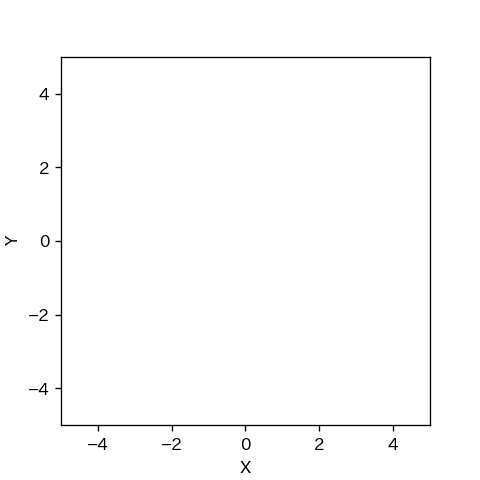

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


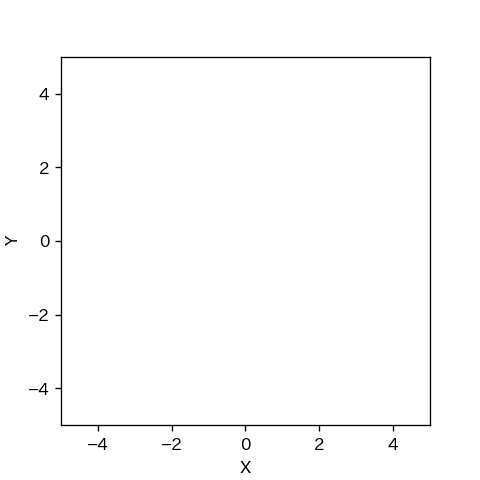

(array([-1.90552674,  0.50072879, -1.46198458]),
 array([ 3.95309683, -1.36756944, -1.11706336]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[2.2499985449637343]
0 真値: [-0.66254147 -1.06587072  4.71698511] 推定値: [-0.86336688 -1.55221645  4.94566401] 誤差: 0.5261777472859888
1
[5.093931975341587]
1 真値: [-2.49861848 -4.17763896  6.31692781] 推定値: [-2.16538694 -3.88083893  6.11165342] 誤差: 0.4462437828247797
2
[0.8411797104899379]
2 真値: [3.51662063 1.85906157 6.31515298] 推定値: [ 3.6120053   1.72406438 -0.18998169] 誤差: 0.1652951181023394
3
[4.727175046418914]
[7.022608607229503]
3 真値: [-1.1962401  -2.59372062  3.80175114] 推定値: [-2.27417728 -3.72421321  3.59214558] 誤差: 1.5620377807560284
[6.661326242317402]
4 真値: [-4.51186734 -4.96982439  6.09011714] 推定値: [-6.12653621 -5.74170841  5.88781895] 誤差: 1.7896816740460098
[3.277726949338272]
5 真値: [-0.05484349  0.77157304  3.27684511] 推定値: [-0.47792826  1.4132462   3.35587495] 誤差: 0.7685994867350084
4
[5.265833444710122, 0.6872879481337003]
6 真値: [3.51426906 0.64428163 5.89643533] 推定値: [3.32336592 0.06926455 6.07185995] 誤差: 0.6058784195792983
5
[3.4792593660086735]
7 真値: [-0.02734335 -0.0713

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[2.445668161331492]
[5.446330567918682]
20 真値: [0.91942541 3.14376703 4.12497821] 推定値: [-0.96805178 -1.96333946  2.95327102] 誤差: 5.44473202690688
[2.4234366625795962]
21 真値: [-2.3585138  -1.25396069  5.24249303] 推定値: [-2.50672811 -0.69527113  5.08657003] 誤差: 0.5780151461661696
14
22 真値: [-4.68166878  0.23107755  5.63088069] 推定値: [2.6213602  2.62138564 2.61525064] 誤差: 7.684256964727045
[2.137269482300316]
23 真値: [-5.84535102  0.67121618  4.66531299] 推定値: [-1.64513719  3.88991305  2.05840623] 誤差: 5.291673249542829
[7.352785808509578]
24 真値: [ 2.26653678 -4.80541633  6.36351043] 推定値: [10.12880602 -0.51367561  7.32645162] 誤差: 8.957361002346659
[4.349540565622412, 5.2672106620210135]
25 真値: [ 3.91104901 -3.20840769  5.04138992] 推定値: [ 4.34527915 -2.71145515  5.22993357] 誤差: 0.6599376092380467
15
26 真値: [-0.21688574  1.90015409  9.05274888] 推定値: [-0.16800379  2.05854943  9.086366  ] 誤差: 0.16576648814851933
16
[4.615599602739892]
[5.143379787155391]
27 真値: [-0.1526721   2.00071126  6.80700246